# 5.1: Going nonlinear with machine learning: kernels, neural networks, and decision trees

In this short notebook we discuss the the underlying framework for performing nonlinear machine learning.  This includes an introduction / comparison of kernels, neural networks, and decision trees, along with many demonstrations involving threse three algorithms.

>The content of this notebook is supplementary material for the textbook Machine Learning Refined (Cambridge University Press, 2016). Visit http://www.mlrefined.com for free chapter downloads and tutorials, and [our Amazon site here](https://www.amazon.com/Machine-Learning-Refined-Foundations-Applications/dp/1107123526/ref=sr_1_1?ie=UTF8&qid=1474491657&sr=8-1&keywords=machine+learning+refined) for details regarding a hard copy of the text.

## What does it mean to go nonlinear in machine learning?

As discussed at length in the text, the general case of regression and classification (and reinforcement learning as well) - in their purest forms - are instances of a classic (centuries-old) area of mathematics known as *function approximation*.  In this field of study, one is given a complete set of input-output pairs defining a target function, with the actual formula for this function unknown.  Using a set of relatively simple elemental (or basis) functions with known formulae, one then approximates the target function by combining these elements in various ways.  Since the formula for each element is known, so too is the formula given by any combination of them.  

This concept is also illustrated in the Python cell below.  Here we show an example of a toy dataset (black points) as well as the true underlying target function (in dashed red).  Here we would like to find a formula for approximating the true target (red-dashed) function.

In [1]:
# load in subdirectories containing python files
import sys
sys.path.append('demo_python_backend_files')

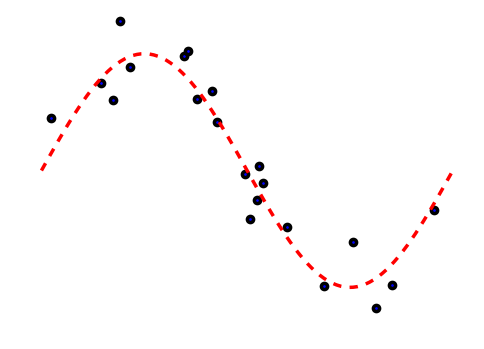

In [2]:
%matplotlib inline
from Data_Fit_Demo1 import Fit_Bases
test = Fit_Bases()
test.load_data('demo_datasets/noisy_sin_sample.csv')
test.load_target('demo_datasets/sin_function.csv')
test.plot_all()

### From supervised learning to function approximation, and back again

Supervised learning problems (regression, classification) are special cases of this classic mathematical problem: function approximation.  The major difference of course is that with supervised learning we have only a (relatively) small sample of the input-output pairs defining the target function, and these samples are themselves noisy.  

The relationship between function approximation and supervised learning is illustrated below in a series of gif annimations (**note: these will not play in the static html version of the notebook on github**).  In the first of these animations a prototypical dataset for regression is shown.  We then show the true underlying target function that generates this data (here shown as the dashed-black curve).  Removing all noise from the dataset we can see how each point then lies exactly on the target function, and how together the points roughly trace it out.  Expanding the dataset by adding more points we eventually fill out the entire target function itself, and we have gone from the problem of supervised learning (regression) to function approximation.

<img src="demo_images/regr_to_func_approx.gif\" width=300 height=300/>

What follows is the analagous animation for classification as well.  In the first animation this process - removing noise (mislabeled points) and filling out the target function - is shown from 'above'.  The same process is then shown from an angle so that the underlying target function - a discontinuous function with nonlinear boundary between its lower and upper steps - is more easily visible.

<img src="demo_images/class_to_func_approx_2d_slow.gif\" width=350 height=300/>


<img src="demo_images/class_to_func_approx_3d.gif\" width=400 height=300/>


## I.  The variety of bases used in machine learning
As in function approximation our ultimate goal with supervised learning is to produce a formula (using basis functions) that closely represents a dataset's underlying target function. However in supervised learning we must do this using only our noisy samples of this target.

Nonetheless, the same tools for function approximation are used for general nonlinear supervised learning.  And it is those tools - these elemental or basis functions - which we explore in this notebook. 

What sort of bases (or collections of relatively simple functions with known formulae) do we have at our disposal?  Lucky for us we can leverage the results of many previous generations' fruitful labor, who put in the work to discover / create a wide range of bases.

## 1.  Fixed kernel bases: pre-defined basis elements
The most basic (and first discovered) basis of elements is called a *fixed kernel basis*.  Such a basis consists of elements like polynomials or sine waves, which have no internal parameters that change their shape.  For example, the first few elements of the polynomial basis looks like 

$f_0(x) = 1$ 

$f_1(x) = x$ 

$f_2(x) = x^2$

$f_3(x) = x^3$


and so forth with the $m^th$ element taking the form $f_m(x) = x^m$.  Once again notice that the basis elements here have no internal parameters that can be tuned.  The only parameter of a polynomial basis element - its *degree* - is defined by the element's index (e.g., $f_m(x)$ has degree parameteter = $n$).

Lets draw out these first few elements of the polynomial basis. 

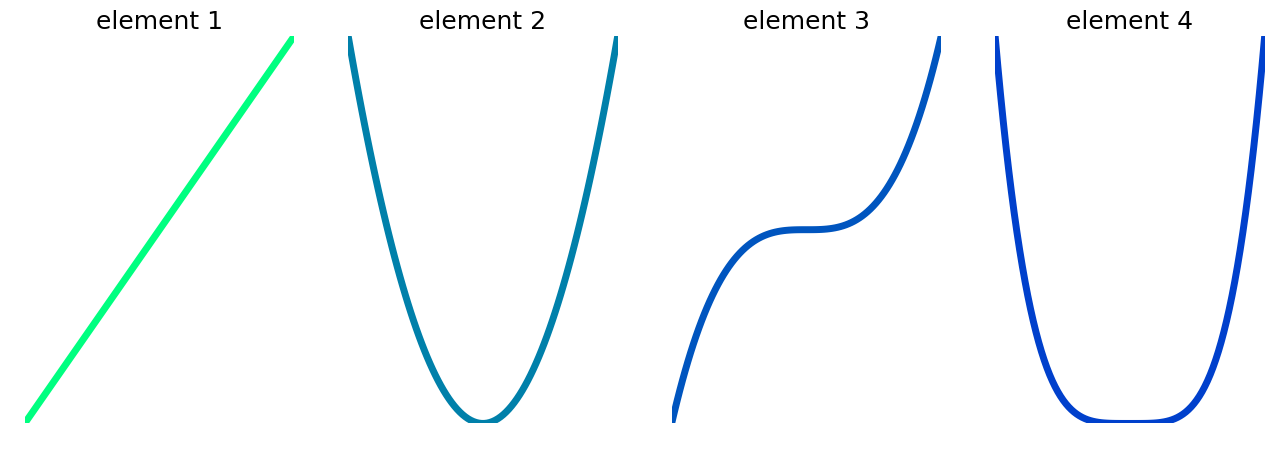

In [3]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_poly()

Now that we know what they look like, lets put them to work.  

First lets use the polynomials to approximate a complete function, solving a pure *function approximation* problem.  That is, lets take a complete function and approximate it using polynomials.

In the Pyton cell that follows we take in a complete function (shown in red) and fit a given number of polynomials to it (shown in blue).  The exact number of elements used is controlled via a slider.

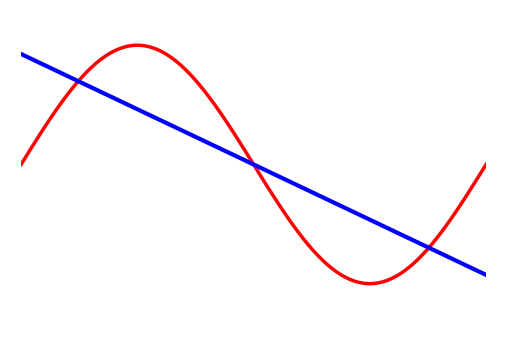

In [4]:
# import class for visualizing complete function approximation
from Function_Fit_Demo1 import Fit_Bases
%matplotlib inline
func_fit = Fit_Bases()
func_fit.load_target('demo_datasets/sin_function.csv')
func_fit.browse_poly_fit()

As you move the slider from left to right, you add another element to the basis approximation.  Notice that as you do this the approximation (in blue) consistently gets better.

Now lets switch over to the supervised learning case - where we only have access to noisy samples of the target function.  In the next Python cell we show this scenario, where you can play around with the number of polynomial elements used by adjusting a slider.  Note that in this demonstration the true completed underlying target function is shown in dashed red, while the noisy samples from it are black points, and once again the approximation is shown in blue.

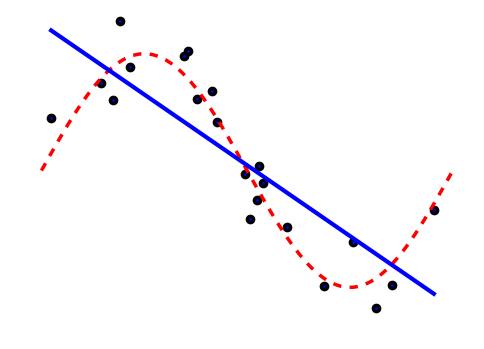

In [5]:
# import class for visualizing complete supervised learning (i.e., noisy sampled function approximation)
from Data_Fit_Demo1 import Fit_Bases
%matplotlib inline
data_fit = Fit_Bases()
data_fit.load_data('demo_datasets/noisy_sin_sample.csv')
data_fit.load_target('demo_datasets/sin_function.csv')
data_fit.browse_poly_fit()

Notice here that the approximation (the blue curve) gets better (i.e., it approximates the red dashed target function) as you increase the number of basis elements used - but only up to a certain number of elements.  Once you surpass this number, the fit actually becomes worse!  This is called *overfitting* and is one key difference between pure function approximation and supervised learning.

Since it is not always the case - as it was with pure function approximation - that more elements provide a better approximation in supervised learning, *cross-validation* must be used to ensure that just enough elements are used, but not too many.  In this example cross-validation would choose the correct (not too small, not too big) value on the slider, i.e., just the right number of elements.

## 2.  Neural networks: compositionally defined basis elements

Unlike polynomials and other fixed kernel bases, each element of a neural network basis has internal parameters that can be tuned to change the shape of the basis function considerably.

Each element of a neural network basis consists of *composition of parameterized functions*.  Typically the functions in this composition, referred to as *activation functions*, are themselves quite simple (e.g., $max$, $tanh$, etc.,) but when composed create a flexible element.

The simplest such neural network basis - referred to as a *neural network basis with 1 hidden layer* - consists of elements that are each just a single elementary function.  While all elements take the same algebraic form, the parameters allow each to take on their own (potentially) unique shape.  

For example, the $m^th$ element of a single hidden layer neural network basis employing the max or 'rectified linear unit' activation function look algebraically like

$f_m(x) = \text{max}(0, c_m + \mathbf{x}^T\mathbf{v}_m)$

In the next Python cell we plot 4 random shapes such a basis element can take given randomly chosen values for its parameters.

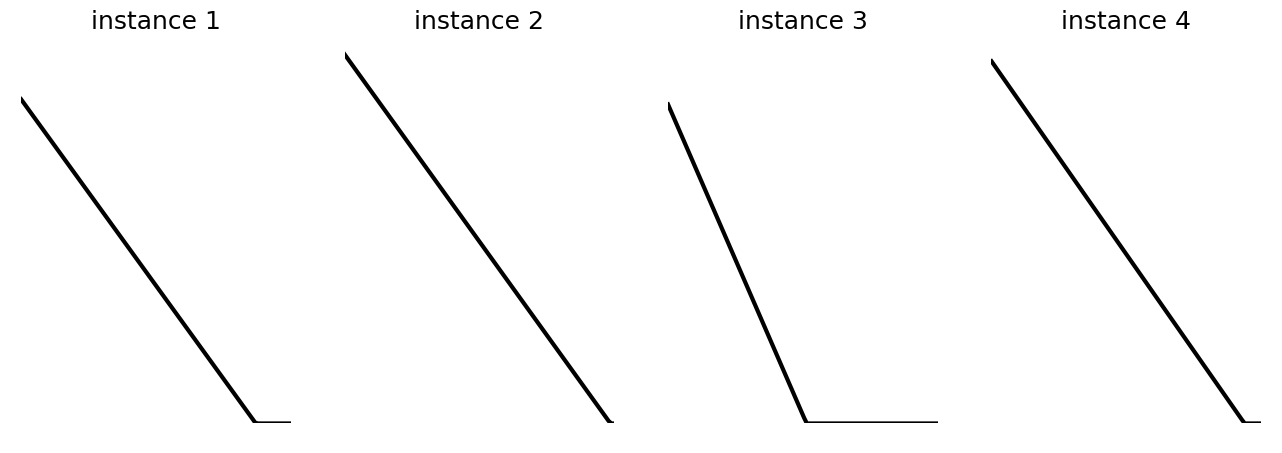

In [6]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_net(num_layers = 1)

Composing the activation function again with itself yeilds a neural network basis element with 2 hidden layers (more specifically we take a linear combination of units that look like the basis element above, and then shove this through the same activation function), whose $m^{th}$ element takes the form

$f_m(x) = \text{max}(0,c_m^{(1)} + \sum_{m_2=1}^{M_2} \text{max}(0,c_{m_2}^{(2)} + \mathbf{x}^T\mathbf{v}_{m_2}^{(2)})v_{{m_2},{m}}^{(1)}$

Such an element is considerably more flexible than the single hidden analog, as the composition allows for a greater array of shapes.

In the next Python cell we illustrate 4 instances of this sort of basis element.  Remember - this is one basis element, with 4 random selections of parameters.

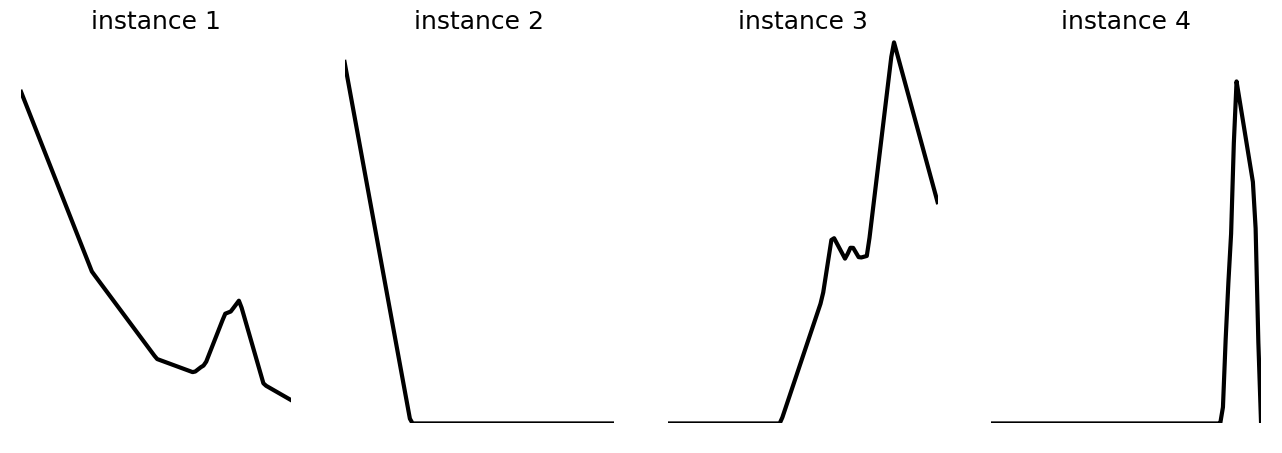

In [7]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_net(num_layers = 2)

And we can go on composing functions, creating neural network bases with more hidden layers.  Typically those with 4 or more layers are referred to as *deep networks*.

Lets take a quick look at 4 random instances of a single deep network basis element - say with 20 hidden layers.

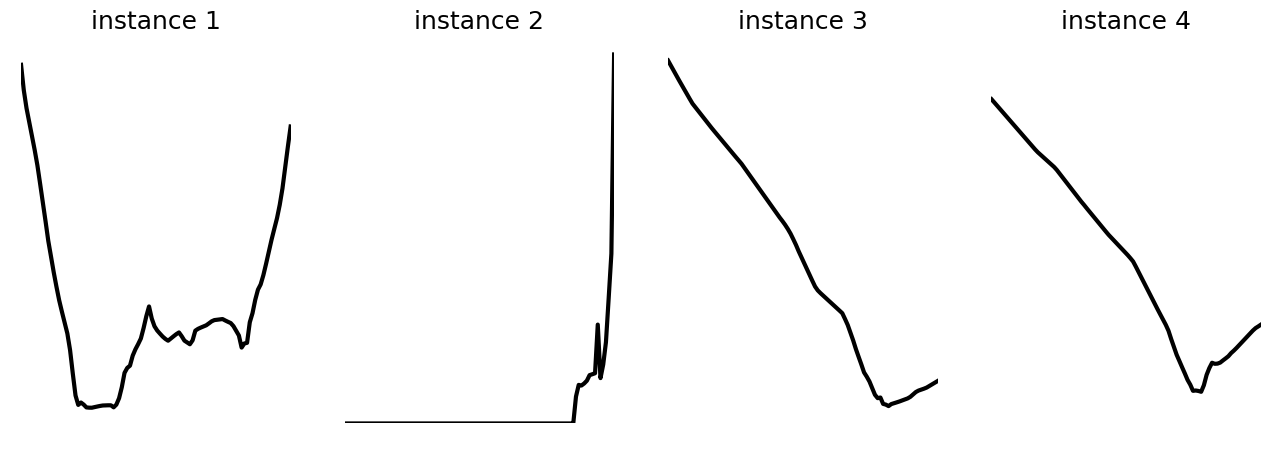

In [8]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_net(num_layers = 20)

Quite a bit of variety in terms of their shapes, no?

Lets use these basis elements to approximate a complete function, as we did above with polynomials.  In the next cell you can control the number of elements (using a slider) from a single hidden layer neural network basis used to approximate a complete function.

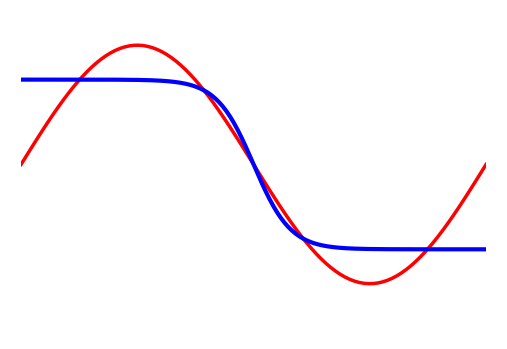

In [9]:
# import class for visualizing complete function approximation
from Function_Fit_Demo1 import Fit_Bases
%matplotlib inline
func_fit = Fit_Bases()
func_fit.load_target('demo_datasets/sin_function.csv')
func_fit.browse_net_fit()

As with the polynomials, again notice that the larger the number of elements used, the better the approximation becomes.

Back to the supervised learning case - where we only have access to noisy samples of the target function.  In the next Python cell we show this scenario, where you can play around with the number of neural network elements used by adjusting a slider.  

Note that in this demonstration the true completed underlying target function is shown in dashed red, while the noisy samples from it are black points, and once again the approximation is shown in blue.

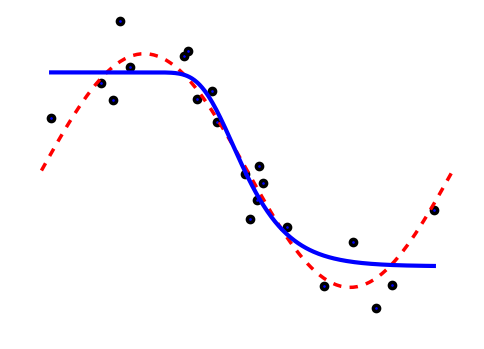

In [10]:
# import class for visualizing complete supervised learning (i.e., noisy sampled function approximation)
from Data_Fit_Demo1 import Fit_Bases
%matplotlib inline
data_fit = Fit_Bases()
data_fit.load_data('demo_datasets/noisy_sin_sample.csv')
data_fit.load_target('demo_datasets/sin_function.csv')
data_fit.browse_net_fit()

As with the polynomial basis previously, notice here that the approximation (the blue curve) gets better (i.e., it approximates the red dashed target function) as you increase the number of neural network basis elements used - but only up to a certain number of elements. Once you surpass this number, the fit actually becomes worse!  This is called *overfitting*.  Again we see one key difference between pure function approximation and supervised learning.

As with polynomials, again *cross-validation* must be used to determine the proper number of elements to use for supervised learning problems.  In this example cross-validation would choose the correct (not too small, not too big) value on the slider, i.e., just the right number of elements.

## 3.  Decision Trees: recursively defined basis elements

Like neural networks, a single tree basis element can take on a wide array of shapes.  Also similar to neural nets, trees can have multiple layers (called the level of *depth*) and the more layers a tree basis element has the wider the array of shapes it can take.  

These 'layers' come not from composing functions together, but by creating flexible functions via a *recursive* process.  Additionally, trees are highly discontinuous and are typically constructed along individual dimensions of a feature space (unlike neural nets, which are tuned along all dimensions of a feature space simultaneously). 

The simplest sort of tree basis consists of indicator functions or, as they are more commonly referred to, *stumps* whose break lies along a single dimension of the feature space.  These are simple step functions whose top and bottom steps break along a single dimension.  

A stump with 1-dimensional input $x$ can be written as 

<img src="demo_images/depth1.png\" width=800 height=600/>

where $V_{1}$ is split point at which the stump changes values, and $y_{1}$ and $y_{2}$ are values taken by the two sides of the stump, respectively, which we refer to as *levels* of the stump.

In the python cell that follows we plot four instances of such a stump basis element.

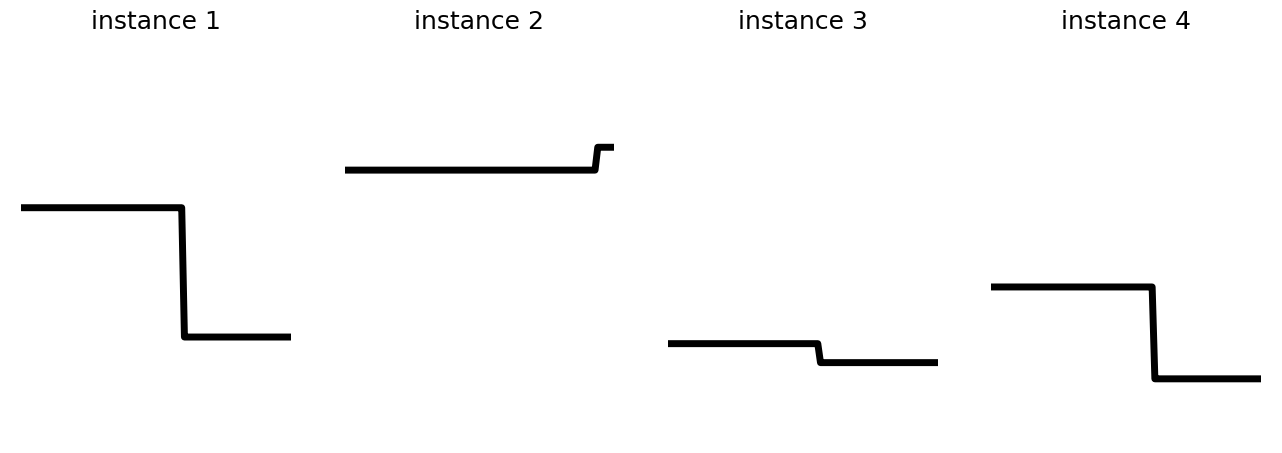

In [11]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_tree(depth = 1)

To create a more flexible decision tree basis function we split each level of the stump.  This gives us a *tree* of depth 2 (our first split gave us a stump, another phrase for stump is tree of depth 1).  

Mathematically we write the form of a tree basis element of depth 2 as 

<img src="demo_images/depth2.png\" width=800 height=600/>

This gives a basis element with four (potentially) distinct levels.  Since the location of the splits and the values of the levels can be set in many ways, this gives each element of a tree basis of depth 2 a good deal more flexibility than stumps. 

In the next python cell we plot

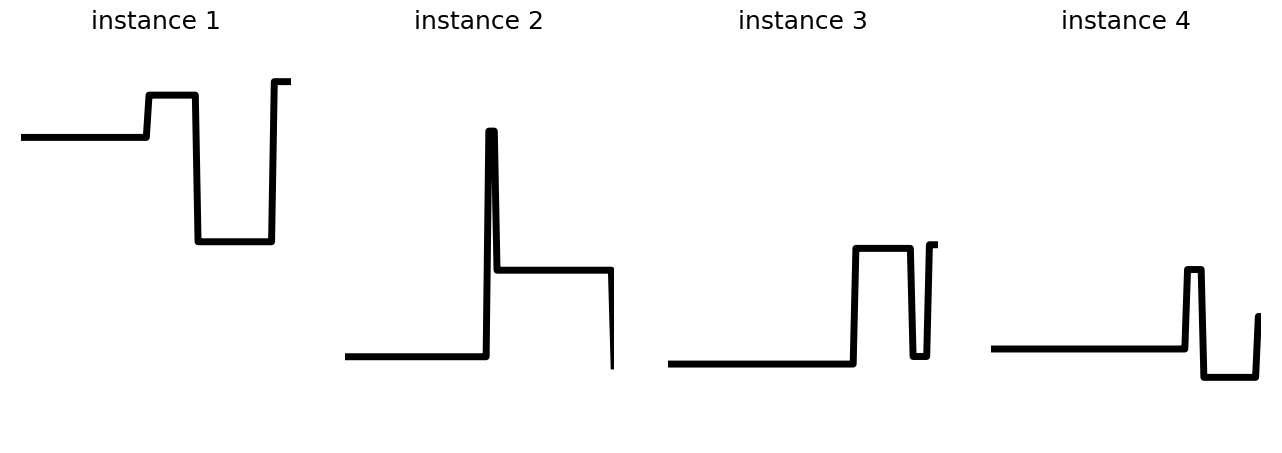

In [12]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_tree(depth = 2)

To make an even more flexible basis elements we simply split the levels of a given tree basis element.   

This gives decision tree elements a distinctly recursive structure: to create a depth (d+1) tree basis element we simply split each level of a basis element of depth d.

This gives a single decision tree element of high depth a great amount of flexibility.  In the next python cell we show 4 instances of a tree basis element with depth = 5.

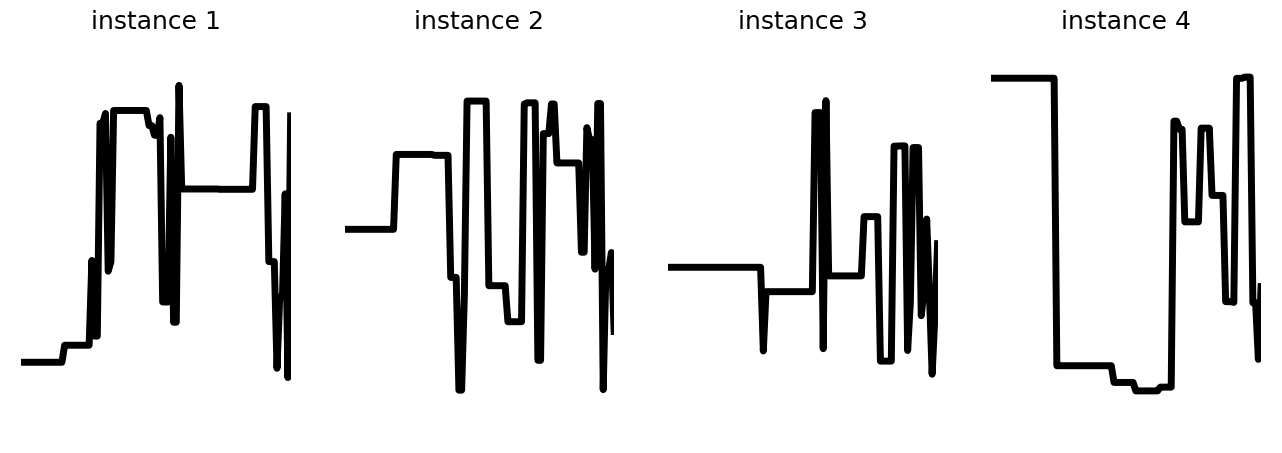

In [13]:
# import Draw_Bases class for visualizing various basis element types
from Draw_Bases import Draw_Bases
%matplotlib inline
bases = Draw_Bases()

# plot the first 4 elements of the polynomial basis
bases.show_1d_tree(depth = 5)

These are extremely flexible.

Lets turn and use these basis elements to approximate a complete function, as we did above with polynomials and neural networks previously.  In the next cell you can control the number of elements (using a slider) from a basis of trees with depth 2 used to approximate a complete function.

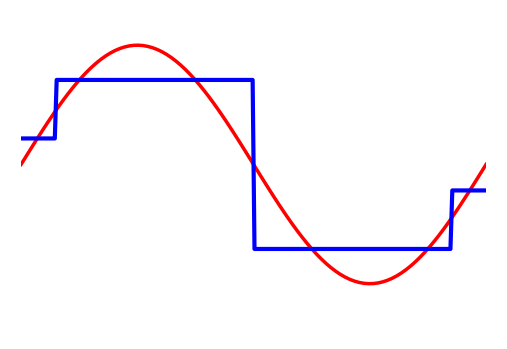

In [14]:
# import class for visualizing complete function approximation
from Function_Fit_Demo1 import Fit_Bases
%matplotlib inline
func_fit = Fit_Bases()
func_fit.load_target('demo_datasets/sin_function.csv')
func_fit.browse_tree_fit()

As with the previous bases, the more elements we use here the better off the approximation.  

Lets turn to the supervised version of the problem, where we have only noisy sasmples of the target function.  In the next Python cell you can control the number of trees used to fit a supervised dataset (using a slider, as with the previous examples).

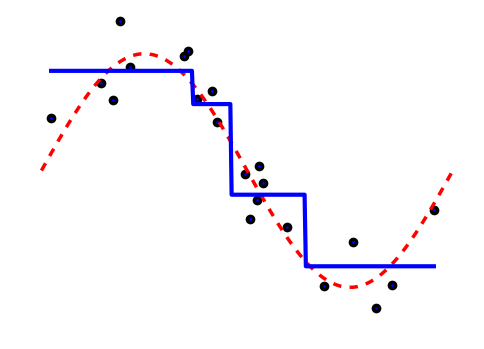

In [15]:
# import class for visualizing complete supervised learning (i.e., noisy sampled function approximation)
from Data_Fit_Demo1 import Fit_Bases
%matplotlib inline
data_fit = Fit_Bases()
data_fit.load_data('demo_datasets/noisy_sin_sample.csv')
data_fit.load_target('demo_datasets/sin_function.csv')
data_fit.browse_tree_fit()

Notice here that the approximation (the blue curve) gets better (i.e., it approximates the red dashed target function) as you increase the number of basis elements used - but only up to a certain number of elements.  Once you surpass this number, the fit actually becomes worse!  This is called *overfitting* and is one key difference between pure function approximation and supervised learning.

Since it is not always the case - as it was with pure function approximation - that more elements provide a better approximation in supervised learning, *cross-validation* must be used to ensure that just enough elements are used, but not too many.  In this example cross-validation would choose the correct (not too small, not too big) value on the slider, i.e., just the right number of elements.

## 4.  Summary of Bases


- In the pure case of function approximation all bases - fixed, compositional (neural nets), and recursive (trees) -  work equally well.  That is they can all approximate a true function as finely as desired.


- Each sort of basis - fixed, neural nets, and trees - for pure function approximation are commonly employed in machine learning.


    - Each element of a fixed basis is a simple continuous function.  All basis elements are distinct in a fixed basis, with each element having its own unique shape.

    - Each element of a neural net basis is a *composition* of simple continuous functions (and so is itself continuous).  All basis elements have the same compositional structure (and mathematical form), however this compositional structure allows each one to take on a wide array of different shapes.

    - Each element of a tree basis is a *recursive combination* of simple discontinuous stump functions, with each stump acting on a single dimension of the feature space (since each tree consists of discontinuous stumps, it too is discontinuous).  All basis elements have the same recursive structure, however this recursive structure allows each one to take on a wide array of different shapes. 
    

- Supervised learning is a special case of *function approximation*, where we have access to only a small (potentially noisy) samples of a target function.  


    - Using this (relatively small) set of input-output pairs we aim to approximate the underlying target function.  In particular, we want a formula for this approximation - hence the use of *bases of functions* with known formulae.  By combining basis elements we create an approximation to the true target function with a known formula.
    
- Because we only have (noisy) samples of the target function with supervised learning
     
     
     - unlike the pure function approximation problem where more elements always produce a better approximation, adding too many basis elements to our supervised approximation creates the problem of *overfitting*.  This requires the use regular use of a *cross-validation* procedure to control the number of basis elements / parameter settings used.
    
    - one basis can work substantially better than others in practice for a particular problem, given the nature of the true target function and the quality (size, distribution, noise-level) of the samples.  e.g., trees often work well for metadata, Fourier elements for periodic data, deep (convolutional) networks for data with local contiguous structure 

# II.  Which basis should I use?

Now that we have seen a number of bases for use for nonlinear supervised learning, how do we decide which one to pick for a given problem?  There  are no clear cut answers for an arbitrary dataset, and for such a case one typically tries several different bases (fitting each via cross-validation) and chooses the best performer.  

Thankfully for certain types of data there are specific guidelines one can follow based on two general criteria

- our understanding of each type of basis (i.e., if a given basis is locally defined as with trees versus globally defined such as fixed basis kernels and neural nets)


- our understanding of a given data type, often largely based on the hard work and experiments of our predecessors and colleagues


Here we briefly discuss a few general guidelines based on these two criteria.

## 1.  Does the structure of the data / target function match one type of basis more than others?

Suppose that our dataset is large enough (and reasonably noise-free) that we can trust it faithfully represents the underlying target function well.  Then - speaking generally - the basis in which this target function most naturally lies is the most appriorate choice (and so will represent the data most effectively).

For example, examine the dataset in the next panel.  These points were generated as noisy samples from a sine wave - the target function (shown in dashed red).  In the subsequent cells you can play with fitting a polynomial, neural network, and tree basis respectively to this dataset.  

Choose the slider-value for each basis type so as to get the best approximation of the target function (in dashed-red).

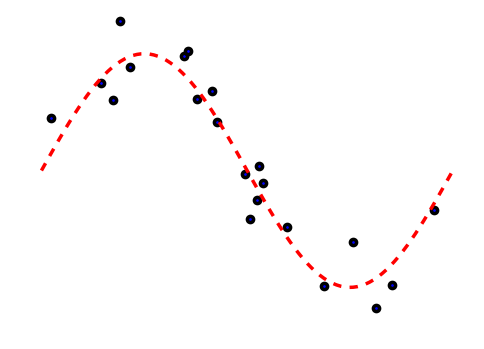

In [16]:
from Data_Fit_Demo1 import Fit_Bases
%matplotlib inline
data_fit = Fit_Bases()
data_fit.load_data('demo_datasets/noisy_sin_sample.csv')
data_fit.load_target('demo_datasets/sin_function.csv')
data_fit.plot_all()

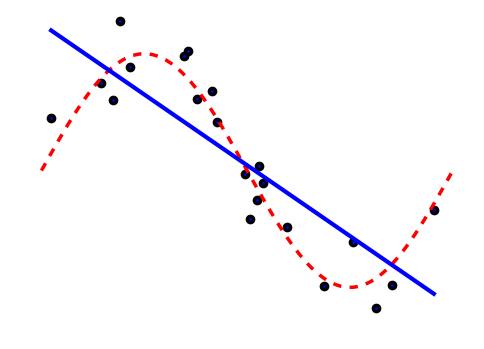

In [17]:
# adjust the slider value to choose the number of polynomial elements to use in the approximation
data_fit.browse_poly_fit()

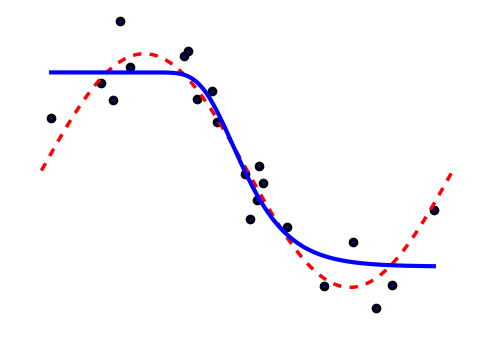

In [18]:
# adjust the slider value to choose the number of neural net elements to use in the approximation
data_fit.browse_net_fit()

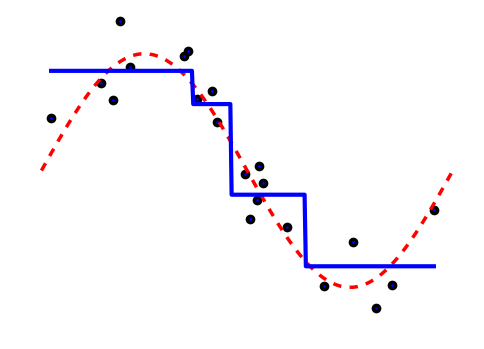

In [19]:
# adjust the slider value to choose the number of trees to use in the approximation
data_fit.browse_tree_fit()

By adjusting each of the sliders, you can see that in this specific instance polynomials provide the best approximation to the target function.  This is because they most naturally approximate the target function (a sine wave) itself, and the dataset is large (and noise-free) enough to represent the target well.

Another example can be seen in the next Python cell.  Here we have generated a dataset based on an underlying sum of tree basis elements.  Once again you can adjust sliders to try to find the best fit for polynomial, neural network, and tree basis elements.  

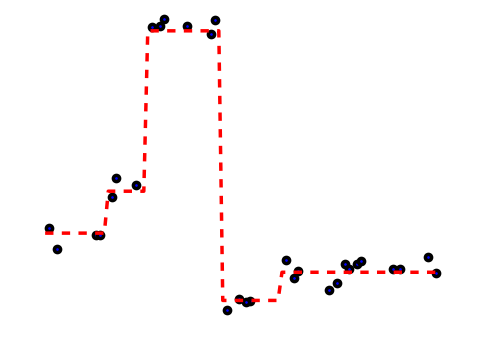

In [20]:
# import class for visualizing complete supervised learning (i.e., noisy sampled function approximation)
from Data_Fit_Demo1 import Fit_Bases
%matplotlib inline
data_fit = Fit_Bases()
data_fit.load_data('demo_datasets/steppy_data.csv')
data_fit.load_target('demo_datasets/steppy_func.csv')
data_fit.plot_all()

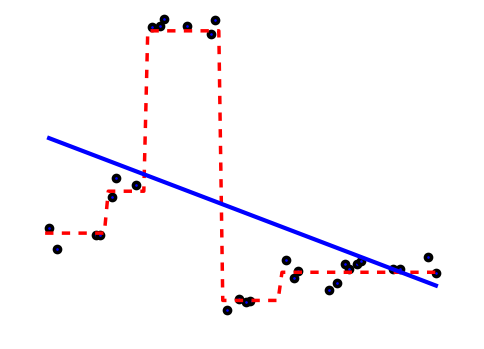

In [21]:
# adjust the slider value to choose the number of polynomial elements to use in the approximation
data_fit.browse_poly_fit()

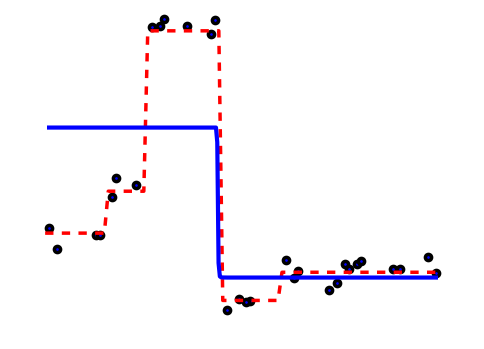

In [22]:
# adjust the slider value to choose the number of neural net elements to use in the approximation
data_fit.browse_net_fit()

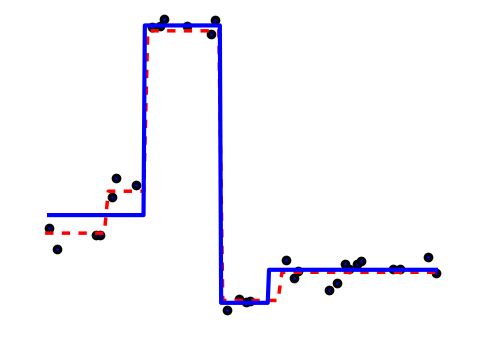

In [23]:
# adjust the slider value to choose the number of trees to use in the approximation
data_fit.browse_tree_fit()

Clearly when tuned properly the tree basis provides the best fit to the target function.  This is not too surprising given how we generated the data!

These are just two toy examples, but they illustrate the point.  Some bases work better than others with specific types of data because these bases better approximate the target function underlying this data.

Some real examples where this occurs: 


-  tree bases tend to work very well for metadata - or data with categorical (and continuous) data


-  neural network bases are often gainfully employed with image and audio data


-  polynomial and other fixed bases (like periodic Fourier bases, consisting of sine waves of varying frequencies / phases) tend to work well in physics and engineering applications


-  neural network and Fourier bases are often a excellent for approximating periodic phenomenon often found in time series

##  2.   Practical considerations

Practical considerations can also guide the choice of basis type.

### Computation time (for training)
Foremost among these considerations is *training computation time*.  In general, deep networks take considerable more computation time to fit (or train) than do trees (which are typically fit via a greedy method as opposed to more traditional schemes like gradient descent). 

### Engineering effort
Another general consideration: the amount of engineering involved in effectively employing a kernelized form of a fixed basis (see Chapter 7 of the book for further details) or a deep neural network (e.g., choosing the number of hidden layers/hidden units/activation function) can also guide the choice of basis in practice.

### Global versus local behavior
Another question to ask is whether or not the phenomenon you're dealing with is *globally or locally* defined.  That is, is the underlying target function defined for large swaths of the input space, or a fairly small region?  

A related question: will the input to future predictions be within the space of the original data (e.g., census data and other metadata sources), or outside of it (e.g., timeseries, various detection problems)?

This helps guide the choice of basis, as some (e.g., trees) consist of locally defined functions, i.e., functions that are only defined over the space of your original data.  Because of this they will often evaluate to a trivial value on new input lying outside the space of the data on which they are trained.

Fixed kernel bases and neural nets, on the other hand, consist of globally defined basis functions.  That is, functions that are defined for every possible input in the space.  Thus if a prediction is required for inputs lying outside the region of the original data, such a globally defined basis is likely preferred (so that you have at least a chance of making an accurate prediction).

### Specific problems
As for a specific example, suppose that given the nature of a dataset's input variable it does not make sense to normalize its values to lie in the range [0,1].  Then polynomials can be a very poor choice of basis/features. This is due to the fact that polynomials grow rapidly for values outside this range e.g., x20 = 1, 048, 576 when x = 2, making the corresponding (closed form) calculations for solving the Least Squares problem difficult if not impossible to perform on a modern computer. 